In [1]:
import numpy as np
import sys

In [2]:
import ccpy

In [3]:
from pyscf import gto, scf

# Testing from PySCF
mol = gto.Mole()
mol.build(
    atom='''F 0.0 0.0 -1.33408
            F 0.0 0.0  1.33408''',
    basis='ccpvdz',
    charge=1,
    spin=1,
    symmetry='D2H',
    cart=True,
    unit='Bohr',
)
mf = scf.ROHF(mol)
mf.kernel()

converged SCF energy = -198.073959812789


-198.07395981278893

In [4]:
from ccpy.interfaces.pyscf_tools import loadFromPyscfMolecular

nfrozen = 2
system, H = loadFromPyscfMolecular(mf, nfrozen, dump_integrals=False)

In [5]:
print(system)

   System Information:
   ----------------------------------------------------
     Number of correlated electrons = 13
     Number of correlated orbitals = 28
     Number of frozen orbitals = 2
     Number of alpha occupied orbitals = 7
     Number of alpha unoccupied orbitals = 21
     Number of beta occupied orbitals = 6
     Number of beta unoccupied orbitals = 22
     Charge = 1
     Point group = D2h
     Spin multiplicity of reference = 2

       MO #      Energy (a.u.)   Symmetry    Occupation
   ----------------------------------------------------
        1       -27.015345          Ag         2.0
        2       -27.014991          B1u         2.0
        3       -2.271013          Ag         2.0
        4       -1.990259          B1u         2.0
        5       -1.311182          B3u         2.0
        6       -1.242453          Ag         2.0
        7       -1.212855          B2u         2.0
        8       -1.177461          B2g         2.0
        9       -0.896237     

In [6]:
from ccpy.models.calculation import Calculation
from ccpy.drivers.calc_driver_main import calc_driver_main

In [7]:
calc = Calculation('ccsd')

In [8]:
calc_driver_main(calc, system, H)

        _____    _____    __ __      __  __   
       /\ __/\  /\ __/\  /_/\__/\  /\  /\  /\ 
       ) )__\/  ) )__\/  ) ) ) ) ) \ \ \/ / / 
      / / /    / / /    /_/ /_/ /   \ \__/ /  
      \ \ \_   \ \ \_   \ \ \_\/     \__/ /   
       ) )__/\  ) )__/\  )_) )       / / /    
       \/___\/  \/___\/  \_\/        \/_/     
                                              

   Authors:
    Karthik Gururangan (gururang@msu.edu)
    J. Emiliano Deustua (edeustua@caltech.edu)
    Affiliated with the Piecuch Group at Michigan State University


   System Information:
   ----------------------------------------------------
     Number of correlated electrons = 13
     Number of correlated orbitals = 28
     Number of frozen orbitals = 2
     Number of alpha occupied orbitals = 7
     Number of alpha unoccupied orbitals = 21
     Number of beta occupied orbitals = 6
     Number of beta unoccupied orbitals = 22
     Charge = 1
     Point group = D2h
     Spin multiplicity of reference = 2

  

(<ccpy.models.operators.ClusterOperator at 0x1189ded90>,
 -198.5196179612483,
 True)

# PES of $\mathrm{F_2^+}$

In [33]:
def geometry(R):

    f2plus = [['F', (0.0, 0.0, -1.0*R/2)],
              ['F', (0.0, 0.0,  1.0*R/2)]]
    return f2plus

def calc_scf(molecular_geometry):
    # Testing from PySCF
    mol = gto.Mole()
    mol.build(
        atom = molecular_geometry,
        basis = 'ccpvdz',
        charge = 1,
        spin = 1,
        symmetry = 'D2H',
        cart = True,
        unit = 'Bohr',
    )
    mf = scf.ROHF(mol)
    mf.kernel()
    return mf

ngeoms = 30
R = np.linspace(0.5, 4, ngeoms)

clusterops = [None] * ngeoms
energy = np.zeros(ngeoms)
is_converged = [None] * ngeoms

geo = geometry(R[0])
mf = calc_scf(geo)

nfrozen = 2
system, H = loadFromPyscfMolecular(mf, nfrozen, dump_integrals=False)
calc = Calculation('ccsd', 1000, energy_shift = 0.6)
clusterops[0], energy[0], is_converged[0] = calc_driver_main(calc, system, H)

for i in range(1, len(R)):
    
    geo = geometry(R[i])
    mf = calc_scf(geo)
    
    nfrozen = 2
    system, H = loadFromPyscfMolecular(mf, nfrozen, dump_integrals=False)
    calc = Calculation('ccsd', 1000, energy_shift = 0.6)
    clusterops[i], energy[i], is_converged[i] = calc_driver_main(calc, system, H, T = clusterops[i-1])
    

converged SCF energy = -152.42652974022
        _____    _____    __ __      __  __   
       /\ __/\  /\ __/\  /_/\__/\  /\  /\  /\ 
       ) )__\/  ) )__\/  ) ) ) ) ) \ \ \/ / / 
      / / /    / / /    /_/ /_/ /   \ \__/ /  
      \ \ \_   \ \ \_   \ \ \_\/     \__/ /   
       ) )__/\  ) )__/\  )_) )       / / /    
       \/___\/  \/___\/  \_\/        \/_/     
                                              

   Authors:
    Karthik Gururangan (gururang@msu.edu)
    J. Emiliano Deustua (edeustua@caltech.edu)
    Affiliated with the Piecuch Group at Michigan State University


   System Information:
   ----------------------------------------------------
     Number of correlated electrons = 13
     Number of correlated orbitals = 28
     Number of frozen orbitals = 2
     Number of alpha occupied orbitals = 7
     Number of alpha unoccupied orbitals = 21
     Number of beta occupied orbitals = 6
     Number of beta unoccupied orbitals = 22
     Charge = 1
     Point group = D2h
   

   Iter       Residuum        deltaE          Ecorr
   0       0.2538257866   -0.2428401945   -0.2428401945   (0.00m 0.10s)
   1       0.0634560476   -0.0204897042   -0.2633298987   (0.00m 0.10s)
   2       0.0316453307   -0.0019280045   -0.2652579032   (0.00m 0.10s)
   3       0.0208571126   0.0004371549   -0.2648207483   (0.00m 0.10s)
   4       0.0154608001   0.0006754548   -0.2641452935   (0.00m 0.10s)
   5       0.0122366481   0.0006054671   -0.2635398264   (0.00m 0.10s)
   DIIS Cycle - 1
   6       0.0100872251   0.0005017103   -0.2630381161   (0.00m 0.10s)
   7       0.0019720625   0.0025160567   -0.2605220595   (0.00m 0.11s)
   8       0.0016263831   -0.0000035600   -0.2605256195   (0.00m 0.10s)
   9       0.0013677800   -0.0000074765   -0.2605330961   (0.00m 0.10s)
   10       0.0011597640   -0.0000074847   -0.2605405808   (0.00m 0.11s)
   11       0.0009882067   -0.0000063388   -0.2605469196   (0.00m 0.14s)
   DIIS Cycle - 2
   12       0.0008450432   -0.0000049509   -0.26055

   DIIS Cycle - 18
   108       0.0000012603   0.0000000010   -0.2605456684   (0.00m 0.11s)
   109       0.0000012512   0.0000000080   -0.2605456604   (0.00m 0.11s)
   110       0.0000012517   -0.0000000006   -0.2605456610   (0.00m 0.10s)
   111       0.0000012522   -0.0000000005   -0.2605456615   (0.00m 0.10s)
   112       0.0000012527   -0.0000000004   -0.2605456619   (0.00m 0.10s)
   113       0.0000012533   -0.0000000004   -0.2605456623   (0.00m 0.10s)
   DIIS Cycle - 19
   114       0.0000012540   -0.0000000003   -0.2605456626   (0.00m 0.10s)
   115       0.0000012227   -0.0000000117   -0.2605456743   (0.00m 0.12s)
   116       0.0000012212   0.0000000020   -0.2605456723   (0.00m 0.10s)
   117       0.0000012200   0.0000000016   -0.2605456707   (0.00m 0.12s)
   118       0.0000012191   0.0000000013   -0.2605456694   (0.00m 0.14s)
   119       0.0000012183   0.0000000010   -0.2605456684   (0.00m 0.11s)
   DIIS Cycle - 20
   120       0.0000012176   0.0000000008   -0.2605456676   (0

   215       0.0000009616   0.0000000003   -0.2605456651   (0.00m 0.11s)
   DIIS Cycle - 36
   216       0.0000009611   0.0000000002   -0.2605456649   (0.00m 0.10s)
   217       0.0000009504   0.0000000064   -0.2605456585   (0.00m 0.10s)
   218       0.0000009506   -0.0000000010   -0.2605456595   (0.00m 0.10s)
   219       0.0000009508   -0.0000000008   -0.2605456603   (0.00m 0.10s)
   220       0.0000009512   -0.0000000006   -0.2605456609   (0.00m 0.10s)
   221       0.0000009516   -0.0000000005   -0.2605456614   (0.00m 0.10s)
   DIIS Cycle - 37
   222       0.0000009521   -0.0000000004   -0.2605456619   (0.00m 0.11s)
   223       0.0000009364   -0.0000000047   -0.2605456666   (0.00m 0.10s)
   224       0.0000009358   0.0000000005   -0.2605456660   (0.00m 0.11s)
   225       0.0000009353   0.0000000004   -0.2605456656   (0.00m 0.10s)
   226       0.0000009348   0.0000000003   -0.2605456653   (0.00m 0.11s)
   227       0.0000009343   0.0000000003   -0.2605456650   (0.00m 0.10s)
   DIIS

   DIIS Cycle - 54
   324       0.0000007695   0.0000000002   -0.2605456648   (0.00m 0.11s)
   325       0.0000007644   0.0000000036   -0.2605456612   (0.00m 0.10s)
   326       0.0000007646   -0.0000000005   -0.2605456616   (0.00m 0.10s)
   327       0.0000007648   -0.0000000004   -0.2605456620   (0.00m 0.10s)
   328       0.0000007651   -0.0000000003   -0.2605456623   (0.00m 0.10s)
   329       0.0000007653   -0.0000000002   -0.2605456625   (0.00m 0.10s)
   DIIS Cycle - 55
   330       0.0000007656   -0.0000000002   -0.2605456628   (0.00m 0.11s)
   331       0.0000007564   -0.0000000036   -0.2605456664   (0.00m 0.11s)
   332       0.0000007559   0.0000000005   -0.2605456659   (0.00m 0.10s)
   333       0.0000007555   0.0000000004   -0.2605456655   (0.00m 0.10s)
   334       0.0000007552   0.0000000003   -0.2605456652   (0.00m 0.10s)
   335       0.0000007548   0.0000000003   -0.2605456649   (0.00m 0.10s)
   DIIS Cycle - 56
   336       0.0000007545   0.0000000002   -0.2605456647   (0

   DIIS Cycle - 72
   432       0.0000006419   0.0000000001   -0.2605456642   (0.00m 0.11s)
   433       0.0000006360   0.0000000041   -0.2605456601   (0.00m 0.11s)
   434       0.0000006360   -0.0000000006   -0.2605456607   (0.00m 0.10s)
   435       0.0000006361   -0.0000000005   -0.2605456612   (0.00m 0.10s)
   436       0.0000006362   -0.0000000004   -0.2605456616   (0.00m 0.10s)
   437       0.0000006363   -0.0000000003   -0.2605456620   (0.00m 0.11s)
   DIIS Cycle - 73
   438       0.0000006365   -0.0000000003   -0.2605456623   (0.00m 0.12s)
   439       0.0000006299   -0.0000000033   -0.2605456655   (0.00m 0.10s)
   440       0.0000006296   0.0000000004   -0.2605456652   (0.00m 0.10s)
   441       0.0000006293   0.0000000003   -0.2605456649   (0.00m 0.10s)
   442       0.0000006290   0.0000000002   -0.2605456646   (0.00m 0.10s)
   443       0.0000006288   0.0000000002   -0.2605456644   (0.00m 0.10s)
   DIIS Cycle - 74
   444       0.0000006285   0.0000000002   -0.2605456643   (0

   DIIS Cycle - 90
   540       0.0000005695   0.0000000001   -0.2605456642   (0.00m 0.11s)
   541       0.0000005670   0.0000000036   -0.2605456607   (0.00m 0.10s)
   542       0.0000005670   -0.0000000005   -0.2605456612   (0.00m 0.10s)
   543       0.0000005670   -0.0000000004   -0.2605456616   (0.00m 0.10s)
   544       0.0000005671   -0.0000000004   -0.2605456620   (0.00m 0.10s)
   545       0.0000005672   -0.0000000003   -0.2605456623   (0.00m 0.10s)
   DIIS Cycle - 91
   546       0.0000005673   -0.0000000002   -0.2605456625   (0.00m 0.10s)
   547       0.0000005638   -0.0000000027   -0.2605456653   (0.00m 0.10s)
   548       0.0000005636   0.0000000003   -0.2605456650   (0.00m 0.10s)
   549       0.0000005634   0.0000000002   -0.2605456647   (0.00m 0.10s)
   550       0.0000005632   0.0000000002   -0.2605456645   (0.00m 0.10s)
   551       0.0000005631   0.0000000002   -0.2605456644   (0.00m 0.10s)
   DIIS Cycle - 92
   552       0.0000005629   0.0000000001   -0.2605456642   (0

   649       0.0000004934   0.0000000001   -0.2605456637   (0.00m 0.11s)
   650       0.0000004932   0.0000000001   -0.2605456636   (0.00m 0.10s)
   651       0.0000004931   0.0000000000   -0.2605456636   (0.00m 0.10s)
   652       0.0000004931   0.0000000000   -0.2605456635   (0.00m 0.11s)
   653       0.0000004930   0.0000000000   -0.2605456635   (0.00m 0.10s)
   DIIS Cycle - 109
   654       0.0000004930   0.0000000000   -0.2605456635   (0.00m 0.11s)
   655       0.0000004910   0.0000000009   -0.2605456626   (0.00m 0.11s)
   656       0.0000004908   -0.0000000002   -0.2605456628   (0.00m 0.10s)
   657       0.0000004907   -0.0000000002   -0.2605456630   (0.00m 0.10s)
   658       0.0000004906   -0.0000000001   -0.2605456631   (0.00m 0.10s)
   659       0.0000004905   -0.0000000001   -0.2605456632   (0.00m 0.10s)
   DIIS Cycle - 110
   660       0.0000004904   -0.0000000001   -0.2605456633   (0.00m 0.10s)
   661       0.0000004889   -0.0000000028   -0.2605456662   (0.00m 0.10s)
   66

   DIIS Cycle - 126
   756       0.0000004693   -0.0000000002   -0.2605456627   (0.00m 0.11s)
   757       0.0000004685   -0.0000000025   -0.2605456652   (0.00m 0.11s)
   758       0.0000004684   0.0000000003   -0.2605456649   (0.00m 0.14s)
   759       0.0000004684   0.0000000002   -0.2605456646   (0.00m 0.15s)
   760       0.0000004684   0.0000000002   -0.2605456644   (0.00m 0.10s)
   761       0.0000004683   0.0000000002   -0.2605456643   (0.00m 0.10s)
   DIIS Cycle - 127
   762       0.0000004683   0.0000000001   -0.2605456641   (0.00m 0.10s)
   763       0.0000004671   0.0000000032   -0.2605456609   (0.00m 0.11s)
   764       0.0000004669   -0.0000000005   -0.2605456614   (0.00m 0.10s)
   765       0.0000004668   -0.0000000004   -0.2605456618   (0.00m 0.11s)
   766       0.0000004667   -0.0000000003   -0.2605456622   (0.00m 0.10s)
   767       0.0000004667   -0.0000000003   -0.2605456624   (0.00m 0.10s)
   DIIS Cycle - 128
   768       0.0000004667   -0.0000000002   -0.2605456627 

   DIIS Cycle - 144
   864       0.0000004244   -0.0000000003   -0.2605456625   (0.00m 0.11s)
   865       0.0000004239   -0.0000000023   -0.2605456647   (0.00m 0.11s)
   866       0.0000004239   0.0000000002   -0.2605456645   (0.00m 0.10s)
   867       0.0000004238   0.0000000002   -0.2605456644   (0.00m 0.10s)
   868       0.0000004238   0.0000000001   -0.2605456642   (0.00m 0.10s)
   869       0.0000004238   0.0000000001   -0.2605456641   (0.00m 0.10s)
   DIIS Cycle - 145
   870       0.0000004238   0.0000000001   -0.2605456640   (0.00m 0.10s)
   871       0.0000004216   0.0000000035   -0.2605456605   (0.00m 0.10s)
   872       0.0000004213   -0.0000000006   -0.2605456611   (0.00m 0.10s)
   873       0.0000004212   -0.0000000005   -0.2605456616   (0.00m 0.10s)
   874       0.0000004211   -0.0000000004   -0.2605456619   (0.00m 0.10s)
   875       0.0000004211   -0.0000000003   -0.2605456622   (0.00m 0.10s)
   DIIS Cycle - 146
   876       0.0000004210   -0.0000000002   -0.2605456625 

   971       0.0000003975   -0.0000000003   -0.2605456624   (0.00m 0.10s)
   DIIS Cycle - 162
   972       0.0000003974   -0.0000000002   -0.2605456626   (0.00m 0.10s)
   973       0.0000003969   -0.0000000020   -0.2605456646   (0.00m 0.10s)
   974       0.0000003968   0.0000000002   -0.2605456644   (0.00m 0.10s)
   975       0.0000003968   0.0000000002   -0.2605456643   (0.00m 0.10s)
   976       0.0000003968   0.0000000001   -0.2605456641   (0.00m 0.10s)
   977       0.0000003968   0.0000000001   -0.2605456640   (0.00m 0.10s)
   DIIS Cycle - 163
   978       0.0000003968   0.0000000001   -0.2605456639   (0.00m 0.10s)
   979       0.0000003955   0.0000000031   -0.2605456609   (0.00m 0.10s)
   980       0.0000003953   -0.0000000005   -0.2605456614   (0.00m 0.10s)
   981       0.0000003952   -0.0000000004   -0.2605456618   (0.00m 0.12s)
   982       0.0000003951   -0.0000000003   -0.2605456622   (0.00m 0.10s)
   983       0.0000003951   -0.0000000003   -0.2605456624   (0.00m 0.10s)
   D

   Iter       Residuum        deltaE          Ecorr
   0       0.1302682497   -0.2612979032   -0.2612979032   (0.00m 0.10s)
   1       0.0216914528   -0.0070831270   -0.2683810302   (0.00m 0.11s)
   2       0.0081380592   -0.0006060638   -0.2689870939   (0.00m 0.10s)
   3       0.0044189202   0.0000632628   -0.2689238311   (0.00m 0.10s)
   4       0.0025504283   0.0000918772   -0.2688319539   (0.00m 0.11s)
   5       0.0014966348   0.0000625305   -0.2687694233   (0.00m 0.10s)
   DIIS Cycle - 1
   6       0.0008858630   0.0000386496   -0.2687307737   (0.00m 0.11s)
   7       0.0000107319   0.0000589355   -0.2686718382   (0.00m 0.11s)
   8       0.0000059725   0.0000000699   -0.2686717683   (0.00m 0.10s)
   9       0.0000035254   0.0000000277   -0.2686717406   (0.00m 0.10s)
   10       0.0000021359   0.0000000142   -0.2686717265   (0.00m 0.10s)
   11       0.0000013111   0.0000000083   -0.2686717181   (0.00m 0.11s)
   DIIS Cycle - 2
   12       0.0000008105   0.0000000052   -0.2686717129

   Iter       Residuum        deltaE          Ecorr
   0       0.1659524788   -0.2776200724   -0.2776200724   (0.00m 0.11s)
   1       0.0278485742   -0.0111127838   -0.2887328562   (0.00m 0.10s)
   2       0.0061062395   -0.0014546596   -0.2901875157   (0.00m 0.10s)
   3       0.0017055923   -0.0002069285   -0.2903944442   (0.00m 0.10s)
   4       0.0005832717   -0.0000305330   -0.2904249772   (0.00m 0.10s)
   5       0.0002319779   -0.0000037532   -0.2904287304   (0.00m 0.10s)
   DIIS Cycle - 1
   6       0.0001022068   0.0000001604   -0.2904285700   (0.00m 0.10s)
   7       0.0000044642   0.0000011293   -0.2904274407   (0.00m 0.11s)
   8       0.0000029148   -0.0000000146   -0.2904274552   (0.00m 0.11s)
   9       0.0000019673   -0.0000000077   -0.2904274630   (0.00m 0.10s)
   10       0.0000013485   -0.0000000039   -0.2904274668   (0.00m 0.10s)
   11       0.0000009369   -0.0000000019   -0.2904274687   (0.00m 0.10s)
   DIIS Cycle - 2
   12       0.0000006629   -0.0000000009   -0.29

   Iter       Residuum        deltaE          Ecorr
   0       0.2114425056   -0.2907998902   -0.2907998902   (0.00m 0.10s)
   1       0.0402728538   -0.0169185160   -0.3077184062   (0.00m 0.11s)
   2       0.0112324053   -0.0026057883   -0.3103241944   (0.00m 0.10s)
   3       0.0039932154   -0.0004806810   -0.3108048754   (0.00m 0.10s)
   4       0.0015693703   -0.0001126318   -0.3109175072   (0.00m 0.11s)
   5       0.0006468643   -0.0000332492   -0.3109507564   (0.00m 0.10s)
   DIIS Cycle - 1
   6       0.0002757127   -0.0000116051   -0.3109623615   (0.00m 0.10s)
   7       0.0000040605   -0.0000078089   -0.3109701704   (0.00m 0.11s)
   8       0.0000023067   -0.0000000131   -0.3109701834   (0.00m 0.10s)
   9       0.0000013757   -0.0000000057   -0.3109701891   (0.00m 0.10s)
   10       0.0000008402   -0.0000000031   -0.3109701922   (0.00m 0.10s)
   11       0.0000005212   -0.0000000018   -0.3109701940   (0.00m 0.10s)
   DIIS Cycle - 2
   12       0.0000003281   -0.0000000011   -0.

   Iter       Residuum        deltaE          Ecorr
   0       0.2674348084   -0.3016921058   -0.3016921058   (0.00m 0.11s)
   1       0.0514148962   -0.0255229933   -0.3272150991   (0.00m 0.11s)
   2       0.0133929564   -0.0039909002   -0.3312059994   (0.00m 0.10s)
   3       0.0044012740   -0.0007103958   -0.3319163952   (0.00m 0.10s)
   4       0.0017196421   -0.0001524506   -0.3320688459   (0.00m 0.10s)
   5       0.0007609434   -0.0000409263   -0.3321097722   (0.00m 0.10s)
   DIIS Cycle - 1
   6       0.0003667706   -0.0000135405   -0.3321233127   (0.00m 0.10s)
   7       0.0000092281   -0.0000094558   -0.3321327686   (0.00m 0.10s)
   8       0.0000053174   0.0000000123   -0.3321327562   (0.00m 0.10s)
   9       0.0000031994   0.0000000108   -0.3321327454   (0.00m 0.11s)
   10       0.0000019616   0.0000000058   -0.3321327396   (0.00m 0.10s)
   11       0.0000012151   0.0000000029   -0.3321327367   (0.00m 0.10s)
   DIIS Cycle - 2
   12       0.0000007581   0.0000000015   -0.33213

   Iter       Residuum        deltaE          Ecorr
   0       0.2042692434   -0.3377472519   -0.3377472519   (0.00m 0.11s)
   1       0.0478487610   -0.0140225520   -0.3517698039   (0.00m 0.12s)
   2       0.0166667500   -0.0025656633   -0.3543354672   (0.00m 0.11s)
   3       0.0068132749   -0.0005672069   -0.3549026741   (0.00m 0.10s)
   4       0.0029166744   -0.0001584330   -0.3550611071   (0.00m 0.10s)
   5       0.0012809090   -0.0000546441   -0.3551157512   (0.00m 0.10s)
   DIIS Cycle - 1
   6       0.0005769035   -0.0000217276   -0.3551374788   (0.00m 0.11s)
   7       0.0000112862   -0.0000175174   -0.3551549962   (0.00m 0.10s)
   8       0.0000070308   -0.0000000024   -0.3551549986   (0.00m 0.11s)
   9       0.0000045364   0.0000000051   -0.3551549935   (0.00m 0.10s)
   10       0.0000029681   0.0000000048   -0.3551549888   (0.00m 0.10s)
   11       0.0000019546   0.0000000031   -0.3551549857   (0.00m 0.10s)
   DIIS Cycle - 2
   12       0.0000012914   0.0000000018   -0.3551

   Iter       Residuum        deltaE          Ecorr
   0       0.2060370016   -0.3609036541   -0.3609036541   (0.00m 0.11s)
   1       0.0406843259   -0.0159371138   -0.3768407678   (0.00m 0.11s)
   2       0.0121909340   -0.0027752629   -0.3796160308   (0.00m 0.10s)
   3       0.0046644289   -0.0005881360   -0.3802041667   (0.00m 0.10s)
   4       0.0020276838   -0.0001576554   -0.3803618222   (0.00m 0.11s)
   5       0.0009954781   -0.0000527012   -0.3804145234   (0.00m 0.10s)
   DIIS Cycle - 1
   6       0.0005646913   -0.0000207076   -0.3804352310   (0.00m 0.10s)
   7       0.0000481648   -0.0000181305   -0.3804533615   (0.00m 0.11s)
   8       0.0000327720   0.0000002262   -0.3804531354   (0.00m 0.10s)
   9       0.0000236387   0.0000001777   -0.3804529577   (0.00m 0.11s)
   10       0.0000175903   0.0000001108   -0.3804528469   (0.00m 0.11s)
   11       0.0000133240   0.0000000662   -0.3804527807   (0.00m 0.10s)
   DIIS Cycle - 2
   12       0.0000101966   0.0000000392   -0.38045

   Iter       Residuum        deltaE          Ecorr
   0       0.2647499090   -0.3812176172   -0.3812176172   (0.00m 0.11s)
   1       0.0639482941   -0.0213787200   -0.4025963372   (0.00m 0.13s)
   2       0.0233557760   -0.0035164759   -0.4061128131   (0.00m 0.12s)
   3       0.0096690144   -0.0006927207   -0.4068055338   (0.00m 0.10s)
   4       0.0041303614   -0.0001756312   -0.4069811650   (0.00m 0.10s)
   5       0.0018027765   -0.0000589251   -0.4070400902   (0.00m 0.10s)
   DIIS Cycle - 1
   6       0.0008098268   -0.0000246641   -0.4070647543   (0.00m 0.11s)
   7       0.0000262587   -0.0000255951   -0.4070903494   (0.00m 0.10s)
   8       0.0000173226   -0.0000001410   -0.4070904904   (0.00m 0.10s)
   9       0.0000117701   -0.0000001099   -0.4070906003   (0.00m 0.10s)
   10       0.0000080914   -0.0000000869   -0.4070906872   (0.00m 0.10s)
   11       0.0000055943   -0.0000000672   -0.4070907544   (0.00m 0.10s)
   DIIS Cycle - 2
   12       0.0000038798   -0.0000000508   -0.

   Iter       Residuum        deltaE          Ecorr
   0       0.1333373087   -0.4247440592   -0.4247440592   (0.00m 0.11s)
   1       0.0313069854   -0.0063683686   -0.4311124279   (0.00m 0.10s)
   2       0.0099427487   -0.0014619423   -0.4325743702   (0.00m 0.10s)
   3       0.0039301071   -0.0004676546   -0.4330420248   (0.00m 0.10s)
   4       0.0018353102   -0.0001903653   -0.4332323901   (0.00m 0.10s)
   5       0.0009723551   -0.0000894795   -0.4333218696   (0.00m 0.10s)
   DIIS Cycle - 1
   6       0.0005656917   -0.0000458590   -0.4333677286   (0.00m 0.11s)
   7       0.0000270077   -0.0000627774   -0.4334305061   (0.00m 0.11s)
   8       0.0000177530   -0.0000000237   -0.4334305298   (0.00m 0.10s)
   9       0.0000124253   -0.0000000136   -0.4334305434   (0.00m 0.10s)
   10       0.0000089393   -0.0000000185   -0.4334305619   (0.00m 0.10s)
   11       0.0000065275   -0.0000000250   -0.4334305869   (0.00m 0.11s)
   DIIS Cycle - 2
   12       0.0000048077   -0.0000000275   -0.

   Iter       Residuum        deltaE          Ecorr
   0       0.0230335205   -0.4557606520   -0.4557606520   (0.00m 0.11s)
   1       0.0077470734   -0.0014949839   -0.4572556359   (0.00m 0.11s)
   2       0.0037782451   -0.0005291306   -0.4577847665   (0.00m 0.10s)
   3       0.0020768047   -0.0002428651   -0.4580276316   (0.00m 0.10s)
   4       0.0012331359   -0.0001261579   -0.4581537894   (0.00m 0.10s)
   5       0.0007849531   -0.0000704372   -0.4582242266   (0.00m 0.10s)
   DIIS Cycle - 1
   6       0.0005307366   -0.0000414397   -0.4582656664   (0.00m 0.11s)
   7       0.0000299031   -0.0000784200   -0.4583440863   (0.00m 0.11s)
   8       0.0000219991   0.0000002991   -0.4583437872   (0.00m 0.10s)
   9       0.0000165363   0.0000001663   -0.4583436209   (0.00m 0.11s)
   10       0.0000125453   0.0000001000   -0.4583435210   (0.00m 0.10s)
   11       0.0000095758   0.0000000606   -0.4583434604   (0.00m 0.11s)
   DIIS Cycle - 2
   12       0.0000073438   0.0000000358   -0.45834

   Iter       Residuum        deltaE          Ecorr
   0       0.0265924958   -0.4791410336   -0.4791410336   (0.00m 0.11s)
   1       0.0076860647   -0.0013667017   -0.4805077353   (0.00m 0.10s)
   2       0.0034161418   -0.0004765548   -0.4809842901   (0.00m 0.10s)
   3       0.0019430818   -0.0002275283   -0.4812118183   (0.00m 0.10s)
   4       0.0012750785   -0.0001256722   -0.4813374905   (0.00m 0.10s)
   5       0.0009064007   -0.0000755077   -0.4814129981   (0.00m 0.10s)
   DIIS Cycle - 1
   6       0.0006720363   -0.0000481524   -0.4814611505   (0.00m 0.10s)
   7       0.0000578923   -0.0001166166   -0.4815777672   (0.00m 0.11s)
   8       0.0000457716   0.0000000395   -0.4815777277   (0.00m 0.10s)
   9       0.0000367863   -0.0000000300   -0.4815777576   (0.00m 0.10s)
   10       0.0000297584   -0.0000000467   -0.4815778043   (0.00m 0.10s)
   11       0.0000241691   -0.0000000536   -0.4815778580   (0.00m 0.11s)
   DIIS Cycle - 2
   12       0.0000196854   -0.0000000561   -0.4

   Iter       Residuum        deltaE          Ecorr
   0       0.0514487428   -0.5004272584   -0.5004272584   (0.00m 0.11s)
   1       0.0122898745   -0.0016768006   -0.5021040590   (0.00m 0.11s)
   2       0.0043071051   -0.0004945523   -0.5025986113   (0.00m 0.10s)
   3       0.0022456459   -0.0002246725   -0.5028232838   (0.00m 0.10s)
   4       0.0015305623   -0.0001277224   -0.5029510062   (0.00m 0.11s)
   5       0.0011503204   -0.0000818884   -0.5030328947   (0.00m 0.10s)
   DIIS Cycle - 1
   6       0.0008893828   -0.0000563111   -0.5030892057   (0.00m 0.11s)
   7       0.0001064903   -0.0001667973   -0.5032560030   (0.00m 0.10s)
   8       0.0000885717   -0.0000010497   -0.5032570527   (0.00m 0.11s)
   9       0.0000743943   -0.0000007746   -0.5032578273   (0.00m 0.10s)
   10       0.0000627826   -0.0000006055   -0.5032584328   (0.00m 0.11s)
   11       0.0000531428   -0.0000004987   -0.5032589316   (0.00m 0.10s)
   DIIS Cycle - 2
   12       0.0000450801   -0.0000004213   -0.

converged SCF energy = -197.92366669543
        _____    _____    __ __      __  __   
       /\ __/\  /\ __/\  /_/\__/\  /\  /\  /\ 
       ) )__\/  ) )__\/  ) ) ) ) ) \ \ \/ / / 
      / / /    / / /    /_/ /_/ /   \ \__/ /  
      \ \ \_   \ \ \_   \ \ \_\/     \__/ /   
       ) )__/\  ) )__/\  )_) )       / / /    
       \/___\/  \/___\/  \_\/        \/_/     
                                              

   Authors:
    Karthik Gururangan (gururang@msu.edu)
    J. Emiliano Deustua (edeustua@caltech.edu)
    Affiliated with the Piecuch Group at Michigan State University


   System Information:
   ----------------------------------------------------
     Number of correlated electrons = 13
     Number of correlated orbitals = 28
     Number of frozen orbitals = 2
     Number of alpha occupied orbitals = 7
     Number of alpha unoccupied orbitals = 21
     Number of beta occupied orbitals = 6
     Number of beta unoccupied orbitals = 22
     Charge = 1
     Point group = D2h
   

   68       0.0000023285   0.0000000024   -0.5235453962   (0.00m 0.10s)
   69       0.0000022992   0.0000000009   -0.5235453953   (0.00m 0.11s)
   70       0.0000022759   0.0000000005   -0.5235453948   (0.00m 0.10s)
   71       0.0000022571   0.0000000004   -0.5235453944   (0.00m 0.11s)
   DIIS Cycle - 12
   72       0.0000022418   0.0000000003   -0.5235453941   (0.00m 0.11s)
   73       0.0000021712   0.0000000008   -0.5235453933   (0.00m 0.11s)
   74       0.0000021724   -0.0000000004   -0.5235453937   (0.00m 0.10s)
   75       0.0000021741   -0.0000000003   -0.5235453941   (0.00m 0.11s)
   76       0.0000021764   -0.0000000002   -0.5235453943   (0.00m 0.10s)
   77       0.0000021792   -0.0000000002   -0.5235453945   (0.00m 0.10s)
   DIIS Cycle - 13
   78       0.0000021826   -0.0000000001   -0.5235453946   (0.00m 0.11s)
   79       0.0000018680   -0.0000000112   -0.5235454058   (0.00m 0.10s)
   80       0.0000018347   0.0000000031   -0.5235454026   (0.00m 0.10s)
   81       0.000001

   177       0.0000006186   0.0000000021   -0.5235454025   (0.00m 0.10s)
   178       0.0000006168   0.0000000015   -0.5235454009   (0.00m 0.11s)
   179       0.0000006152   0.0000000012   -0.5235453997   (0.00m 0.10s)
   DIIS Cycle - 30
   180       0.0000006138   0.0000000009   -0.5235453988   (0.00m 0.11s)
   181       0.0000006047   0.0000000085   -0.5235453903   (0.00m 0.10s)
   182       0.0000006049   -0.0000000008   -0.5235453911   (0.00m 0.10s)
   183       0.0000006054   -0.0000000006   -0.5235453917   (0.00m 0.10s)
   184       0.0000006060   -0.0000000005   -0.5235453922   (0.00m 0.11s)
   185       0.0000006068   -0.0000000004   -0.5235453927   (0.00m 0.10s)
   DIIS Cycle - 31
   186       0.0000006077   -0.0000000004   -0.5235453930   (0.00m 0.11s)
   187       0.0000005632   -0.0000000168   -0.5235454098   (0.00m 0.10s)
   188       0.0000005595   0.0000000033   -0.5235454065   (0.00m 0.10s)
   189       0.0000005569   0.0000000024   -0.5235454041   (0.00m 0.10s)
   190 

   285       0.0000002497   0.0000000000   -0.5235453946   (0.00m 0.10s)
   286       0.0000002497   -0.0000000000   -0.5235453946   (0.00m 0.11s)
   287       0.0000002497   -0.0000000000   -0.5235453946   (0.00m 0.10s)
   DIIS Cycle - 48
   288       0.0000002497   -0.0000000000   -0.5235453946   (0.00m 0.11s)
   289       0.0000002493   -0.0000000009   -0.5235453954   (0.00m 0.10s)
   290       0.0000002493   0.0000000002   -0.5235453953   (0.00m 0.11s)
   291       0.0000002493   0.0000000001   -0.5235453951   (0.00m 0.10s)
   292       0.0000002493   0.0000000001   -0.5235453950   (0.00m 0.10s)
   293       0.0000002493   0.0000000001   -0.5235453950   (0.00m 0.10s)
   DIIS Cycle - 49
   294       0.0000002493   0.0000000001   -0.5235453949   (0.00m 0.11s)
   295       0.0000002491   0.0000000003   -0.5235453946   (0.00m 0.10s)
   296       0.0000002491   0.0000000000   -0.5235453946   (0.00m 0.11s)
   297       0.0000002491   -0.0000000000   -0.5235453946   (0.00m 0.10s)
   298  

   392       0.0000002470   0.0000000000   -0.5235453945   (0.00m 0.10s)
   393       0.0000002470   -0.0000000000   -0.5235453945   (0.00m 0.10s)
   394       0.0000002470   -0.0000000000   -0.5235453945   (0.00m 0.14s)
   395       0.0000002470   -0.0000000000   -0.5235453946   (0.00m 0.14s)
   DIIS Cycle - 66
   396       0.0000002470   -0.0000000000   -0.5235453946   (0.00m 0.12s)
   397       0.0000002469   -0.0000000007   -0.5235453952   (0.00m 0.10s)
   398       0.0000002469   0.0000000002   -0.5235453951   (0.00m 0.10s)
   399       0.0000002469   0.0000000001   -0.5235453949   (0.00m 0.10s)
   400       0.0000002469   0.0000000001   -0.5235453948   (0.00m 0.10s)
   401       0.0000002469   0.0000000001   -0.5235453948   (0.00m 0.10s)
   DIIS Cycle - 67
   402       0.0000002469   0.0000000000   -0.5235453947   (0.00m 0.11s)
   403       0.0000002468   0.0000000002   -0.5235453945   (0.00m 0.11s)
   404       0.0000002468   0.0000000000   -0.5235453945   (0.00m 0.10s)
   405  

   500       0.0000002443   -0.0000000000   -0.5235453945   (0.00m 0.10s)
   501       0.0000002443   -0.0000000000   -0.5235453945   (0.00m 0.10s)
   502       0.0000002443   -0.0000000000   -0.5235453945   (0.00m 0.10s)
   503       0.0000002443   -0.0000000000   -0.5235453945   (0.00m 0.10s)
   DIIS Cycle - 84
   504       0.0000002443   -0.0000000000   -0.5235453945   (0.00m 0.11s)
   505       0.0000002443   -0.0000000000   -0.5235453946   (0.00m 0.10s)
   506       0.0000002443   0.0000000000   -0.5235453945   (0.00m 0.10s)
   507       0.0000002443   0.0000000000   -0.5235453945   (0.00m 0.10s)
   508       0.0000002443   0.0000000000   -0.5235453945   (0.00m 0.10s)
   509       0.0000002443   0.0000000000   -0.5235453945   (0.00m 0.10s)
   DIIS Cycle - 85
   510       0.0000002443   0.0000000000   -0.5235453945   (0.00m 0.11s)
   511       0.0000002442   -0.0000000000   -0.5235453946   (0.00m 0.10s)
   512       0.0000002441   0.0000000000   -0.5235453945   (0.00m 0.11s)
   513

   607       0.0000002421   -0.0000000002   -0.5235453946   (0.00m 0.10s)
   608       0.0000002421   0.0000000000   -0.5235453945   (0.00m 0.10s)
   609       0.0000002421   0.0000000000   -0.5235453945   (0.00m 0.10s)
   610       0.0000002421   0.0000000000   -0.5235453945   (0.00m 0.10s)
   611       0.0000002421   0.0000000000   -0.5235453945   (0.00m 0.10s)
   DIIS Cycle - 102
   612       0.0000002421   0.0000000000   -0.5235453945   (0.00m 0.11s)
   613       0.0000002421   0.0000000002   -0.5235453943   (0.00m 0.10s)
   614       0.0000002421   -0.0000000000   -0.5235453943   (0.00m 0.10s)
   615       0.0000002421   -0.0000000000   -0.5235453943   (0.00m 0.10s)
   616       0.0000002421   -0.0000000000   -0.5235453944   (0.00m 0.12s)
   617       0.0000002421   -0.0000000000   -0.5235453944   (0.00m 0.10s)
   DIIS Cycle - 103
   618       0.0000002421   -0.0000000000   -0.5235453944   (0.00m 0.11s)
   619       0.0000002420   -0.0000000003   -0.5235453947   (0.00m 0.10s)
   6

   714       0.0000002408   0.0000000001   -0.5235453946   (0.00m 0.11s)
   715       0.0000002407   0.0000000002   -0.5235453944   (0.00m 0.11s)
   716       0.0000002407   0.0000000000   -0.5235453944   (0.00m 0.10s)
   717       0.0000002407   0.0000000000   -0.5235453944   (0.00m 0.10s)
   718       0.0000002407   -0.0000000000   -0.5235453944   (0.00m 0.10s)
   719       0.0000002407   -0.0000000000   -0.5235453944   (0.00m 0.10s)
   DIIS Cycle - 120
   720       0.0000002407   -0.0000000000   -0.5235453944   (0.00m 0.10s)
   721       0.0000002402   -0.0000000012   -0.5235453956   (0.00m 0.10s)
   722       0.0000002401   0.0000000003   -0.5235453953   (0.00m 0.11s)
   723       0.0000002401   0.0000000002   -0.5235453950   (0.00m 0.10s)
   724       0.0000002401   0.0000000002   -0.5235453949   (0.00m 0.10s)
   725       0.0000002401   0.0000000001   -0.5235453948   (0.00m 0.10s)
   DIIS Cycle - 121
   726       0.0000002401   0.0000000001   -0.5235453947   (0.00m 0.10s)
   727 

   821       0.0000002350   0.0000000000   -0.5235453942   (0.00m 0.10s)
   DIIS Cycle - 137
   822       0.0000002350   0.0000000000   -0.5235453942   (0.00m 0.11s)
   823       0.0000002349   -0.0000000000   -0.5235453943   (0.00m 0.10s)
   824       0.0000002349   0.0000000000   -0.5235453943   (0.00m 0.10s)
   825       0.0000002349   0.0000000000   -0.5235453943   (0.00m 0.10s)
   826       0.0000002349   0.0000000000   -0.5235453943   (0.00m 0.10s)
   827       0.0000002349   0.0000000000   -0.5235453943   (0.00m 0.10s)
   DIIS Cycle - 138
   828       0.0000002349   0.0000000000   -0.5235453943   (0.00m 0.11s)
   829       0.0000002347   -0.0000000000   -0.5235453943   (0.00m 0.11s)
   830       0.0000002347   0.0000000000   -0.5235453943   (0.00m 0.10s)
   831       0.0000002347   0.0000000000   -0.5235453943   (0.00m 0.11s)
   832       0.0000002347   0.0000000000   -0.5235453942   (0.00m 0.10s)
   833       0.0000002347   0.0000000000   -0.5235453942   (0.00m 0.10s)
   DIIS C

   929       0.0000002316   -0.0000000000   -0.5235453941   (0.00m 0.10s)
   DIIS Cycle - 155
   930       0.0000002315   -0.0000000000   -0.5235453941   (0.00m 0.11s)
   931       0.0000002314   -0.0000000002   -0.5235453943   (0.00m 0.10s)
   932       0.0000002314   0.0000000000   -0.5235453943   (0.00m 0.11s)
   933       0.0000002314   0.0000000000   -0.5235453942   (0.00m 0.10s)
   934       0.0000002314   0.0000000000   -0.5235453942   (0.00m 0.11s)
   935       0.0000002314   0.0000000000   -0.5235453942   (0.00m 0.10s)
   DIIS Cycle - 156
   936       0.0000002314   0.0000000000   -0.5235453942   (0.00m 0.11s)
   937       0.0000002312   0.0000000000   -0.5235453942   (0.00m 0.10s)
   938       0.0000002312   0.0000000000   -0.5235453942   (0.00m 0.10s)
   939       0.0000002312   0.0000000000   -0.5235453942   (0.00m 0.10s)
   940       0.0000002312   0.0000000000   -0.5235453941   (0.00m 0.11s)
   941       0.0000002311   0.0000000000   -0.5235453941   (0.00m 0.10s)
   DIIS 

   Iter       Residuum        deltaE          Ecorr
   0       0.1341761841   -0.5254953522   -0.5254953522   (0.00m 0.11s)
   1       0.0206058913   -0.0057612421   -0.5312565943   (0.00m 0.11s)
   2       0.0049851804   -0.0010714652   -0.5323280595   (0.00m 0.10s)
   3       0.0025887559   -0.0003052240   -0.5326332835   (0.00m 0.10s)
   4       0.0019300021   -0.0001435634   -0.5327768469   (0.00m 0.10s)
   5       0.0015245067   -0.0000940863   -0.5328709332   (0.00m 0.10s)
   DIIS Cycle - 1
   6       0.0012168155   -0.0000700480   -0.5329409812   (0.00m 0.11s)
   7       0.0001937470   -0.0002600232   -0.5332010043   (0.00m 0.10s)
   8       0.0001732946   -0.0000014219   -0.5332024262   (0.00m 0.10s)
   9       0.0001566168   -0.0000012883   -0.5332037145   (0.00m 0.10s)
   10       0.0001425088   -0.0000011387   -0.5332048532   (0.00m 0.10s)
   11       0.0001303999   -0.0000010063   -0.5332058595   (0.00m 0.11s)
   DIIS Cycle - 2
   12       0.0001199065   -0.0000008876   -0.

   109       0.0000041621   -0.0000001345   -0.5332124934   (0.00m 0.10s)
   110       0.0000041240   0.0000000301   -0.5332124633   (0.00m 0.11s)
   111       0.0000041004   0.0000000234   -0.5332124399   (0.00m 0.10s)
   112       0.0000040846   0.0000000177   -0.5332124221   (0.00m 0.10s)
   113       0.0000040738   0.0000000134   -0.5332124087   (0.00m 0.10s)
   DIIS Cycle - 19
   114       0.0000040662   0.0000000102   -0.5332123985   (0.00m 0.11s)
   115       0.0000040139   0.0000000483   -0.5332123502   (0.00m 0.10s)
   116       0.0000040135   -0.0000000022   -0.5332123523   (0.00m 0.10s)
   117       0.0000040154   -0.0000000023   -0.5332123547   (0.00m 0.10s)
   118       0.0000040186   -0.0000000021   -0.5332123568   (0.00m 0.10s)
   119       0.0000040231   -0.0000000018   -0.5332123585   (0.00m 0.10s)
   DIIS Cycle - 20
   120       0.0000040288   -0.0000000014   -0.5332123599   (0.00m 0.10s)
   121       0.0000037053   -0.0000001333   -0.5332124933   (0.00m 0.11s)
   122

   217       0.0000010304   -0.0000000370   -0.5332124004   (0.00m 0.10s)
   218       0.0000010139   0.0000000095   -0.5332123909   (0.00m 0.10s)
   219       0.0000010056   0.0000000070   -0.5332123839   (0.00m 0.10s)
   220       0.0000010007   0.0000000051   -0.5332123789   (0.00m 0.10s)
   221       0.0000009976   0.0000000037   -0.5332123752   (0.00m 0.10s)
   DIIS Cycle - 37
   222       0.0000009959   0.0000000027   -0.5332123724   (0.00m 0.11s)
   223       0.0000009885   0.0000000136   -0.5332123588   (0.00m 0.10s)
   224       0.0000009879   -0.0000000011   -0.5332123599   (0.00m 0.11s)
   225       0.0000009877   -0.0000000009   -0.5332123609   (0.00m 0.10s)
   226       0.0000009877   -0.0000000008   -0.5332123616   (0.00m 0.11s)
   227       0.0000009880   -0.0000000006   -0.5332123622   (0.00m 0.10s)
   DIIS Cycle - 38
   228       0.0000009885   -0.0000000005   -0.5332123627   (0.00m 0.11s)
   229       0.0000009066   -0.0000000095   -0.5332123722   (0.00m 0.10s)
   230

   DIIS Cycle - 54
   324       0.0000004924   -0.0000000003   -0.5332123632   (0.00m 0.11s)
   325       0.0000004915   -0.0000000002   -0.5332123634   (0.00m 0.10s)
   326       0.0000004915   -0.0000000002   -0.5332123636   (0.00m 0.10s)
   327       0.0000004915   -0.0000000002   -0.5332123637   (0.00m 0.10s)
   328       0.0000004916   -0.0000000001   -0.5332123639   (0.00m 0.10s)
   329       0.0000004917   -0.0000000001   -0.5332123640   (0.00m 0.10s)
   DIIS Cycle - 55
   330       0.0000004917   -0.0000000001   -0.5332123641   (0.00m 0.10s)
   331       0.0000004911   0.0000000013   -0.5332123627   (0.00m 0.10s)
   332       0.0000004911   -0.0000000003   -0.5332123630   (0.00m 0.10s)
   333       0.0000004912   -0.0000000003   -0.5332123633   (0.00m 0.10s)
   334       0.0000004913   -0.0000000002   -0.5332123635   (0.00m 0.10s)
   335       0.0000004915   -0.0000000002   -0.5332123637   (0.00m 0.11s)
   DIIS Cycle - 56
   336       0.0000004916   -0.0000000001   -0.533212363

   DIIS Cycle - 72
   432       0.0000004893   -0.0000000001   -0.5332123640   (0.00m 0.11s)
   433       0.0000004888   0.0000000005   -0.5332123635   (0.00m 0.10s)
   434       0.0000004888   -0.0000000002   -0.5332123637   (0.00m 0.10s)
   435       0.0000004889   -0.0000000001   -0.5332123638   (0.00m 0.11s)
   436       0.0000004890   -0.0000000001   -0.5332123639   (0.00m 0.10s)
   437       0.0000004891   -0.0000000001   -0.5332123640   (0.00m 0.10s)
   DIIS Cycle - 73
   438       0.0000004892   -0.0000000001   -0.5332123641   (0.00m 0.12s)
   439       0.0000004887   0.0000000007   -0.5332123634   (0.00m 0.10s)
   440       0.0000004888   -0.0000000002   -0.5332123636   (0.00m 0.12s)
   441       0.0000004889   -0.0000000002   -0.5332123637   (0.00m 0.11s)
   442       0.0000004890   -0.0000000001   -0.5332123638   (0.00m 0.10s)
   443       0.0000004891   -0.0000000001   -0.5332123640   (0.00m 0.11s)
   DIIS Cycle - 74
   444       0.0000004892   -0.0000000001   -0.5332123640

   539       0.0000004887   -0.0000000001   -0.5332123640   (0.00m 0.11s)
   DIIS Cycle - 90
   540       0.0000004888   -0.0000000001   -0.5332123641   (0.00m 0.11s)
   541       0.0000004883   0.0000000005   -0.5332123636   (0.00m 0.10s)
   542       0.0000004884   -0.0000000001   -0.5332123638   (0.00m 0.11s)
   543       0.0000004885   -0.0000000001   -0.5332123639   (0.00m 0.11s)
   544       0.0000004886   -0.0000000001   -0.5332123640   (0.00m 0.11s)
   545       0.0000004886   -0.0000000001   -0.5332123641   (0.00m 0.10s)
   DIIS Cycle - 91
   546       0.0000004887   -0.0000000001   -0.5332123641   (0.00m 0.11s)
   547       0.0000004883   0.0000000006   -0.5332123636   (0.00m 0.10s)
   548       0.0000004884   -0.0000000001   -0.5332123637   (0.00m 0.10s)
   549       0.0000004885   -0.0000000001   -0.5332123638   (0.00m 0.11s)
   550       0.0000004886   -0.0000000001   -0.5332123640   (0.00m 0.10s)
   551       0.0000004887   -0.0000000001   -0.5332123640   (0.00m 0.11s)
  

   647       0.0000004886   -0.0000000001   -0.5332123641   (0.00m 0.10s)
   DIIS Cycle - 108
   648       0.0000004887   -0.0000000001   -0.5332123641   (0.00m 0.11s)
   649       0.0000004882   0.0000000004   -0.5332123637   (0.00m 0.10s)
   650       0.0000004883   -0.0000000001   -0.5332123638   (0.00m 0.11s)
   651       0.0000004884   -0.0000000001   -0.5332123639   (0.00m 0.10s)
   652       0.0000004885   -0.0000000001   -0.5332123640   (0.00m 0.10s)
   653       0.0000004885   -0.0000000001   -0.5332123641   (0.00m 0.10s)
   DIIS Cycle - 109
   654       0.0000004886   -0.0000000001   -0.5332123641   (0.00m 0.10s)
   655       0.0000004882   0.0000000005   -0.5332123637   (0.00m 0.10s)
   656       0.0000004883   -0.0000000001   -0.5332123638   (0.00m 0.10s)
   657       0.0000004884   -0.0000000001   -0.5332123639   (0.00m 0.11s)
   658       0.0000004885   -0.0000000001   -0.5332123640   (0.00m 0.10s)
   659       0.0000004886   -0.0000000001   -0.5332123641   (0.00m 0.10s)


   755       0.0000004885   -0.0000000001   -0.5332123641   (0.00m 0.10s)
   DIIS Cycle - 126
   756       0.0000004886   -0.0000000001   -0.5332123641   (0.00m 0.11s)
   757       0.0000004882   0.0000000004   -0.5332123637   (0.00m 0.10s)
   758       0.0000004883   -0.0000000001   -0.5332123638   (0.00m 0.10s)
   759       0.0000004883   -0.0000000001   -0.5332123639   (0.00m 0.10s)
   760       0.0000004884   -0.0000000001   -0.5332123640   (0.00m 0.10s)
   761       0.0000004885   -0.0000000001   -0.5332123641   (0.00m 0.10s)
   DIIS Cycle - 127
   762       0.0000004886   -0.0000000001   -0.5332123642   (0.00m 0.10s)
   763       0.0000004882   0.0000000005   -0.5332123637   (0.00m 0.11s)
   764       0.0000004883   -0.0000000001   -0.5332123638   (0.00m 0.10s)
   765       0.0000004883   -0.0000000001   -0.5332123639   (0.00m 0.14s)
   766       0.0000004884   -0.0000000001   -0.5332123640   (0.00m 0.11s)
   767       0.0000004885   -0.0000000001   -0.5332123641   (0.00m 0.10s)


   863       0.0000004885   -0.0000000001   -0.5332123641   (0.00m 0.11s)
   DIIS Cycle - 144
   864       0.0000004886   -0.0000000001   -0.5332123642   (0.00m 0.10s)
   865       0.0000004882   0.0000000004   -0.5332123637   (0.00m 0.10s)
   866       0.0000004882   -0.0000000001   -0.5332123638   (0.00m 0.11s)
   867       0.0000004883   -0.0000000001   -0.5332123639   (0.00m 0.10s)
   868       0.0000004884   -0.0000000001   -0.5332123640   (0.00m 0.10s)
   869       0.0000004885   -0.0000000001   -0.5332123641   (0.00m 0.10s)
   DIIS Cycle - 145
   870       0.0000004886   -0.0000000001   -0.5332123642   (0.00m 0.11s)
   871       0.0000004882   0.0000000004   -0.5332123637   (0.00m 0.10s)
   872       0.0000004882   -0.0000000001   -0.5332123638   (0.00m 0.11s)
   873       0.0000004883   -0.0000000001   -0.5332123639   (0.00m 0.10s)
   874       0.0000004884   -0.0000000001   -0.5332123640   (0.00m 0.10s)
   875       0.0000004885   -0.0000000001   -0.5332123641   (0.00m 0.10s)


   DIIS Cycle - 162
   972       0.0000004886   -0.0000000001   -0.5332123642   (0.00m 0.11s)
   973       0.0000004882   0.0000000004   -0.5332123637   (0.00m 0.10s)
   974       0.0000004882   -0.0000000001   -0.5332123638   (0.00m 0.10s)
   975       0.0000004883   -0.0000000001   -0.5332123639   (0.00m 0.10s)
   976       0.0000004884   -0.0000000001   -0.5332123640   (0.00m 0.10s)
   977       0.0000004885   -0.0000000001   -0.5332123641   (0.00m 0.10s)
   DIIS Cycle - 163
   978       0.0000004886   -0.0000000001   -0.5332123642   (0.00m 0.11s)
   979       0.0000004882   0.0000000004   -0.5332123637   (0.00m 0.11s)
   980       0.0000004882   -0.0000000001   -0.5332123638   (0.00m 0.10s)
   981       0.0000004883   -0.0000000001   -0.5332123639   (0.00m 0.11s)
   982       0.0000004884   -0.0000000001   -0.5332123640   (0.00m 0.10s)
   983       0.0000004885   -0.0000000001   -0.5332123641   (0.00m 0.10s)
   DIIS Cycle - 164
   984       0.0000004886   -0.0000000001   -0.5332123

   35       0.0000439636   -0.0000000604   -0.5425904354   (0.00m 0.11s)
   DIIS Cycle - 6
   36       0.0000438594   -0.0000000502   -0.5425904856   (0.00m 0.10s)
   37       0.0000428469   -0.0000007936   -0.5425912792   (0.00m 0.10s)
   38       0.0000428581   0.0000000804   -0.5425911988   (0.00m 0.11s)
   39       0.0000428951   0.0000000720   -0.5425911267   (0.00m 0.10s)
   40       0.0000429517   0.0000000616   -0.5425910651   (0.00m 0.11s)
   41       0.0000430259   0.0000000524   -0.5425910128   (0.00m 0.10s)
   DIIS Cycle - 7
   42       0.0000431167   0.0000000442   -0.5425909685   (0.00m 0.11s)
   43       0.0000404255   0.0000006847   -0.5425902838   (0.00m 0.11s)
   44       0.0000402667   -0.0000000817   -0.5425903655   (0.00m 0.10s)
   45       0.0000401633   -0.0000000665   -0.5425904320   (0.00m 0.10s)
   46       0.0000400733   -0.0000000527   -0.5425904846   (0.00m 0.10s)
   47       0.0000399908   -0.0000000423   -0.5425905270   (0.00m 0.11s)
   DIIS Cycle - 8
   

   143       0.0000204925   -0.0000000360   -0.5425905508   (0.00m 0.10s)
   DIIS Cycle - 24
   144       0.0000204496   -0.0000000302   -0.5425905810   (0.00m 0.11s)
   145       0.0000201426   -0.0000002435   -0.5425908245   (0.00m 0.11s)
   146       0.0000201669   0.0000000124   -0.5425908122   (0.00m 0.10s)
   147       0.0000201968   0.0000000098   -0.5425908024   (0.00m 0.10s)
   148       0.0000202310   0.0000000080   -0.5425907944   (0.00m 0.11s)
   149       0.0000202695   0.0000000065   -0.5425907878   (0.00m 0.10s)
   DIIS Cycle - 25
   150       0.0000203125   0.0000000053   -0.5425907825   (0.00m 0.11s)
   151       0.0000188043   0.0000005089   -0.5425902735   (0.00m 0.11s)
   152       0.0000186865   -0.0000000835   -0.5425903571   (0.00m 0.10s)
   153       0.0000185982   -0.0000000645   -0.5425904216   (0.00m 0.11s)
   154       0.0000185295   -0.0000000532   -0.5425904748   (0.00m 0.10s)
   155       0.0000184748   -0.0000000445   -0.5425905193   (0.00m 0.11s)
   DII

   250       0.0000091694   -0.0000000126   -0.5425907871   (0.00m 0.11s)
   251       0.0000091681   -0.0000000110   -0.5425907981   (0.00m 0.10s)
   DIIS Cycle - 42
   252       0.0000091675   -0.0000000095   -0.5425908076   (0.00m 0.11s)
   253       0.0000091583   -0.0000000306   -0.5425908382   (0.00m 0.11s)
   254       0.0000091570   -0.0000000003   -0.5425908385   (0.00m 0.10s)
   255       0.0000091560   -0.0000000010   -0.5425908394   (0.00m 0.11s)
   256       0.0000091552   -0.0000000012   -0.5425908407   (0.00m 0.10s)
   257       0.0000091546   -0.0000000013   -0.5425908420   (0.00m 0.11s)
   DIIS Cycle - 43
   258       0.0000091543   -0.0000000014   -0.5425908434   (0.00m 0.11s)
   259       0.0000088980   0.0000000104   -0.5425908330   (0.00m 0.11s)
   260       0.0000088718   -0.0000000003   -0.5425908333   (0.00m 0.10s)
   261       0.0000088584   -0.0000000023   -0.5425908356   (0.00m 0.10s)
   262       0.0000088511   -0.0000000025   -0.5425908381   (0.00m 0.10s)
 

   357       0.0000084393   0.0000000031   -0.5425907922   (0.00m 0.10s)
   358       0.0000084382   0.0000000013   -0.5425907909   (0.00m 0.11s)
   359       0.0000084374   0.0000000004   -0.5425907905   (0.00m 0.10s)
   DIIS Cycle - 60
   360       0.0000084367   -0.0000000001   -0.5425907906   (0.00m 0.11s)
   361       0.0000084229   0.0000000110   -0.5425907796   (0.00m 0.11s)
   362       0.0000084220   -0.0000000024   -0.5425907820   (0.00m 0.10s)
   363       0.0000084218   -0.0000000028   -0.5425907848   (0.00m 0.10s)
   364       0.0000084219   -0.0000000028   -0.5425907876   (0.00m 0.10s)
   365       0.0000084223   -0.0000000026   -0.5425907902   (0.00m 0.10s)
   DIIS Cycle - 61
   366       0.0000084229   -0.0000000024   -0.5425907926   (0.00m 0.11s)
   367       0.0000083857   -0.0000000376   -0.5425908302   (0.00m 0.10s)
   368       0.0000083823   0.0000000145   -0.5425908157   (0.00m 0.11s)
   369       0.0000083809   0.0000000084   -0.5425908072   (0.00m 0.10s)
   370

   464       0.0000064068   0.0000000012   -0.5425906549   (0.00m 0.10s)
   465       0.0000064068   0.0000000009   -0.5425906541   (0.00m 0.10s)
   466       0.0000064070   0.0000000005   -0.5425906536   (0.00m 0.10s)
   467       0.0000064073   0.0000000002   -0.5425906533   (0.00m 0.11s)
   DIIS Cycle - 78
   468       0.0000064077   0.0000000000   -0.5425906533   (0.00m 0.10s)
   469       0.0000063760   0.0000000559   -0.5425905974   (0.00m 0.10s)
   470       0.0000063719   -0.0000000089   -0.5425906063   (0.00m 0.11s)
   471       0.0000063694   -0.0000000080   -0.5425906143   (0.00m 0.10s)
   472       0.0000063679   -0.0000000067   -0.5425906210   (0.00m 0.11s)
   473       0.0000063668   -0.0000000054   -0.5425906264   (0.00m 0.10s)
   DIIS Cycle - 79
   474       0.0000063661   -0.0000000044   -0.5425906308   (0.00m 0.11s)
   475       0.0000063616   -0.0000000292   -0.5425906600   (0.00m 0.10s)
   476       0.0000063614   0.0000000028   -0.5425906572   (0.00m 0.10s)
   477 

   572       0.0000056704   0.0000000038   -0.5425905949   (0.00m 0.10s)
   573       0.0000056577   0.0000000022   -0.5425905928   (0.00m 0.11s)
   574       0.0000056491   0.0000000012   -0.5425905916   (0.00m 0.10s)
   575       0.0000056432   0.0000000003   -0.5425905913   (0.00m 0.11s)
   DIIS Cycle - 96
   576       0.0000056391   -0.0000000004   -0.5425905917   (0.00m 0.11s)
   577       0.0000056264   0.0000000087   -0.5425905830   (0.00m 0.11s)
   578       0.0000056263   -0.0000000057   -0.5425905888   (0.00m 0.10s)
   579       0.0000056264   -0.0000000044   -0.5425905932   (0.00m 0.11s)
   580       0.0000056269   -0.0000000035   -0.5425905966   (0.00m 0.10s)
   581       0.0000056274   -0.0000000028   -0.5425905994   (0.00m 0.11s)
   DIIS Cycle - 97
   582       0.0000056282   -0.0000000023   -0.5425906016   (0.00m 0.11s)
   583       0.0000055463   0.0000000082   -0.5425905934   (0.00m 0.11s)
   584       0.0000055407   -0.0000000015   -0.5425905950   (0.00m 0.10s)
   585

   679       0.0000048387   0.0000000231   -0.5425905525   (0.00m 0.10s)
   680       0.0000048173   -0.0000000016   -0.5425905541   (0.00m 0.11s)
   681       0.0000048033   -0.0000000006   -0.5425905547   (0.00m 0.10s)
   682       0.0000047933   -0.0000000002   -0.5425905549   (0.00m 0.11s)
   683       0.0000047858   -0.0000000001   -0.5425905550   (0.00m 0.10s)
   DIIS Cycle - 114
   684       0.0000047803   -0.0000000002   -0.5425905552   (0.00m 0.11s)
   685       0.0000047632   -0.0000000074   -0.5425905626   (0.00m 0.10s)
   686       0.0000047635   -0.0000000000   -0.5425905627   (0.00m 0.11s)
   687       0.0000047639   -0.0000000001   -0.5425905628   (0.00m 0.10s)
   688       0.0000047644   -0.0000000002   -0.5425905630   (0.00m 0.11s)
   689       0.0000047650   -0.0000000003   -0.5425905633   (0.00m 0.10s)
   DIIS Cycle - 115
   690       0.0000047656   -0.0000000003   -0.5425905636   (0.00m 0.10s)
   691       0.0000043394   0.0000002037   -0.5425903599   (0.00m 0.11s)


   787       0.0000038207   0.0000000182   -0.5425905094   (0.00m 0.10s)
   788       0.0000038198   -0.0000000018   -0.5425905112   (0.00m 0.11s)
   789       0.0000038190   -0.0000000017   -0.5425905130   (0.00m 0.10s)
   790       0.0000038184   -0.0000000015   -0.5425905145   (0.00m 0.11s)
   791       0.0000038179   -0.0000000013   -0.5425905157   (0.00m 0.10s)
   DIIS Cycle - 132
   792       0.0000038175   -0.0000000011   -0.5425905168   (0.00m 0.11s)
   793       0.0000038004   -0.0000000303   -0.5425905471   (0.00m 0.10s)
   794       0.0000037994   0.0000000073   -0.5425905398   (0.00m 0.10s)
   795       0.0000037991   0.0000000047   -0.5425905350   (0.00m 0.10s)
   796       0.0000037992   0.0000000032   -0.5425905318   (0.00m 0.11s)
   797       0.0000037994   0.0000000022   -0.5425905295   (0.00m 0.10s)
   DIIS Cycle - 133
   798       0.0000037997   0.0000000016   -0.5425905280   (0.00m 0.11s)
   799       0.0000037916   0.0000000163   -0.5425905116   (0.00m 0.10s)
   80

   DIIS Cycle - 149
   894       0.0000035343   -0.0000000004   -0.5425905100   (0.00m 0.11s)
   895       0.0000035146   -0.0000000226   -0.5425905326   (0.00m 0.10s)
   896       0.0000035122   0.0000000065   -0.5425905261   (0.00m 0.10s)
   897       0.0000035110   0.0000000042   -0.5425905220   (0.00m 0.11s)
   898       0.0000035103   0.0000000028   -0.5425905191   (0.00m 0.10s)
   899       0.0000035099   0.0000000020   -0.5425905171   (0.00m 0.11s)
   DIIS Cycle - 150
   900       0.0000035098   0.0000000014   -0.5425905157   (0.00m 0.11s)
   901       0.0000035060   0.0000000124   -0.5425905033   (0.00m 0.11s)
   902       0.0000035056   -0.0000000013   -0.5425905046   (0.00m 0.10s)
   903       0.0000035053   -0.0000000011   -0.5425905057   (0.00m 0.10s)
   904       0.0000035051   -0.0000000010   -0.5425905067   (0.00m 0.10s)
   905       0.0000035050   -0.0000000008   -0.5425905075   (0.00m 0.11s)
   DIIS Cycle - 151
   906       0.0000035050   -0.0000000007   -0.5425905082 

converged SCF energy = -197.869116823176
        _____    _____    __ __      __  __   
       /\ __/\  /\ __/\  /_/\__/\  /\  /\  /\ 
       ) )__\/  ) )__\/  ) ) ) ) ) \ \ \/ / / 
      / / /    / / /    /_/ /_/ /   \ \__/ /  
      \ \ \_   \ \ \_   \ \ \_\/     \__/ /   
       ) )__/\  ) )__/\  )_) )       / / /    
       \/___\/  \/___\/  \_\/        \/_/     
                                              

   Authors:
    Karthik Gururangan (gururang@msu.edu)
    J. Emiliano Deustua (edeustua@caltech.edu)
    Affiliated with the Piecuch Group at Michigan State University


   System Information:
   ----------------------------------------------------
     Number of correlated electrons = 13
     Number of correlated orbitals = 28
     Number of frozen orbitals = 2
     Number of alpha occupied orbitals = 7
     Number of alpha unoccupied orbitals = 21
     Number of beta occupied orbitals = 6
     Number of beta unoccupied orbitals = 22
     Charge = 1
     Point group = D2h
  

   67       0.0000817452   -0.0000019240   -0.5516992134   (0.00m 0.10s)
   68       0.0000813721   0.0000003185   -0.5516988949   (0.00m 0.11s)
   69       0.0000810937   0.0000002181   -0.5516986767   (0.00m 0.10s)
   70       0.0000808642   0.0000001603   -0.5516985165   (0.00m 0.10s)
   71       0.0000806735   0.0000001209   -0.5516983955   (0.00m 0.10s)
   DIIS Cycle - 12
   72       0.0000805178   0.0000000922   -0.5516983033   (0.00m 0.11s)
   73       0.0000779918   0.0000020730   -0.5516962304   (0.00m 0.10s)
   74       0.0000778247   -0.0000003620   -0.5516965924   (0.00m 0.10s)
   75       0.0000777828   -0.0000002942   -0.5516968866   (0.00m 0.11s)
   76       0.0000778185   -0.0000002371   -0.5516971237   (0.00m 0.10s)
   77       0.0000779123   -0.0000001904   -0.5516973141   (0.00m 0.10s)
   DIIS Cycle - 13
   78       0.0000780527   -0.0000001524   -0.5516974666   (0.00m 0.11s)
   79       0.0000741332   -0.0000016419   -0.5516991084   (0.00m 0.11s)
   80       0.00007

   175       0.0000232421   -0.0000005115   -0.5516982558   (0.00m 0.12s)
   176       0.0000229341   0.0000001140   -0.5516981418   (0.00m 0.13s)
   177       0.0000227541   0.0000000844   -0.5516980574   (0.00m 0.11s)
   178       0.0000226220   0.0000000641   -0.5516979933   (0.00m 0.10s)
   179       0.0000225137   0.0000000491   -0.5516979443   (0.00m 0.10s)
   DIIS Cycle - 30
   180       0.0000224200   0.0000000375   -0.5516979067   (0.00m 0.11s)
   181       0.0000216110   0.0000003417   -0.5516975650   (0.00m 0.10s)
   182       0.0000216501   -0.0000000561   -0.5516976211   (0.00m 0.10s)
   183       0.0000217037   -0.0000000432   -0.5516976643   (0.00m 0.10s)
   184       0.0000217680   -0.0000000334   -0.5516976978   (0.00m 0.10s)
   185       0.0000218413   -0.0000000260   -0.5516977237   (0.00m 0.10s)
   DIIS Cycle - 31
   186       0.0000219224   -0.0000000202   -0.5516977440   (0.00m 0.10s)
   187       0.0000191548   -0.0000003896   -0.5516981336   (0.00m 0.10s)
   188

   283       0.0000045740   0.0000000738   -0.5516977098   (0.00m 0.10s)
   284       0.0000045446   -0.0000000060   -0.5516977159   (0.00m 0.11s)
   285       0.0000045228   -0.0000000059   -0.5516977218   (0.00m 0.10s)
   286       0.0000045045   -0.0000000054   -0.5516977272   (0.00m 0.10s)
   287       0.0000044884   -0.0000000048   -0.5516977320   (0.00m 0.10s)
   DIIS Cycle - 48
   288       0.0000044739   -0.0000000042   -0.5516977362   (0.00m 0.11s)
   289       0.0000043332   -0.0000000673   -0.5516978035   (0.00m 0.10s)
   290       0.0000043373   0.0000000059   -0.5516977976   (0.00m 0.10s)
   291       0.0000043433   0.0000000052   -0.5516977924   (0.00m 0.10s)
   292       0.0000043509   0.0000000045   -0.5516977879   (0.00m 0.11s)
   293       0.0000043598   0.0000000038   -0.5516977841   (0.00m 0.10s)
   DIIS Cycle - 49
   294       0.0000043699   0.0000000033   -0.5516977809   (0.00m 0.11s)
   295       0.0000040361   0.0000000635   -0.5516977173   (0.00m 0.11s)
   296 

   391       0.0000026323   -0.0000000122   -0.5516977729   (0.00m 0.10s)
   392       0.0000026304   0.0000000031   -0.5516977698   (0.00m 0.11s)
   393       0.0000026289   0.0000000023   -0.5516977675   (0.00m 0.10s)
   394       0.0000026276   0.0000000017   -0.5516977658   (0.00m 0.10s)
   395       0.0000026264   0.0000000013   -0.5516977644   (0.00m 0.10s)
   DIIS Cycle - 66
   396       0.0000026254   0.0000000010   -0.5516977634   (0.00m 0.11s)
   397       0.0000026127   0.0000000162   -0.5516977472   (0.00m 0.10s)
   398       0.0000026127   -0.0000000031   -0.5516977503   (0.00m 0.11s)
   399       0.0000026131   -0.0000000024   -0.5516977527   (0.00m 0.10s)
   400       0.0000026139   -0.0000000018   -0.5516977545   (0.00m 0.10s)
   401       0.0000026148   -0.0000000014   -0.5516977559   (0.00m 0.10s)
   DIIS Cycle - 67
   402       0.0000026159   -0.0000000011   -0.5516977570   (0.00m 0.11s)
   403       0.0000025930   -0.0000000171   -0.5516977741   (0.00m 0.10s)
   404

   499       0.0000023898   -0.0000000162   -0.5516977733   (0.00m 0.10s)
   500       0.0000023887   0.0000000029   -0.5516977704   (0.00m 0.11s)
   501       0.0000023880   0.0000000023   -0.5516977681   (0.00m 0.10s)
   502       0.0000023873   0.0000000018   -0.5516977664   (0.00m 0.10s)
   503       0.0000023867   0.0000000014   -0.5516977649   (0.00m 0.10s)
   DIIS Cycle - 84
   504       0.0000023863   0.0000000011   -0.5516977638   (0.00m 0.11s)
   505       0.0000023807   0.0000000133   -0.5516977506   (0.00m 0.10s)
   506       0.0000023808   -0.0000000019   -0.5516977525   (0.00m 0.10s)
   507       0.0000023810   -0.0000000016   -0.5516977541   (0.00m 0.11s)
   508       0.0000023814   -0.0000000012   -0.5516977553   (0.00m 0.10s)
   509       0.0000023818   -0.0000000010   -0.5516977563   (0.00m 0.10s)
   DIIS Cycle - 85
   510       0.0000023824   -0.0000000008   -0.5516977571   (0.00m 0.11s)
   511       0.0000023707   -0.0000000160   -0.5516977731   (0.00m 0.10s)
   512

   607       0.0000022297   -0.0000000172   -0.5516977750   (0.00m 0.10s)
   608       0.0000022286   0.0000000033   -0.5516977717   (0.00m 0.10s)
   609       0.0000022279   0.0000000026   -0.5516977691   (0.00m 0.10s)
   610       0.0000022273   0.0000000020   -0.5516977670   (0.00m 0.10s)
   611       0.0000022268   0.0000000016   -0.5516977654   (0.00m 0.10s)
   DIIS Cycle - 102
   612       0.0000022264   0.0000000012   -0.5516977642   (0.00m 0.10s)
   613       0.0000022228   0.0000000108   -0.5516977533   (0.00m 0.11s)
   614       0.0000022230   -0.0000000014   -0.5516977547   (0.00m 0.10s)
   615       0.0000022232   -0.0000000011   -0.5516977558   (0.00m 0.10s)
   616       0.0000022236   -0.0000000008   -0.5516977566   (0.00m 0.10s)
   617       0.0000022240   -0.0000000007   -0.5516977573   (0.00m 0.10s)
   DIIS Cycle - 103
   618       0.0000022244   -0.0000000005   -0.5516977578   (0.00m 0.10s)
   619       0.0000022130   -0.0000000176   -0.5516977754   (0.00m 0.10s)
   6

   715       0.0000020736   -0.0000000215   -0.5516977801   (0.00m 0.10s)
   716       0.0000020721   0.0000000045   -0.5516977756   (0.00m 0.11s)
   717       0.0000020712   0.0000000035   -0.5516977721   (0.00m 0.10s)
   718       0.0000020704   0.0000000027   -0.5516977694   (0.00m 0.10s)
   719       0.0000020699   0.0000000021   -0.5516977673   (0.00m 0.10s)
   DIIS Cycle - 120
   720       0.0000020694   0.0000000017   -0.5516977656   (0.00m 0.11s)
   721       0.0000020668   0.0000000094   -0.5516977562   (0.00m 0.10s)
   722       0.0000020669   -0.0000000007   -0.5516977569   (0.00m 0.11s)
   723       0.0000020672   -0.0000000006   -0.5516977575   (0.00m 0.10s)
   724       0.0000020675   -0.0000000005   -0.5516977580   (0.00m 0.11s)
   725       0.0000020679   -0.0000000004   -0.5516977584   (0.00m 0.10s)
   DIIS Cycle - 121
   726       0.0000020683   -0.0000000003   -0.5516977586   (0.00m 0.11s)
   727       0.0000020545   -0.0000000222   -0.5516977808   (0.00m 0.10s)
   7

   DIIS Cycle - 137
   822       0.0000019167   -0.0000000002   -0.5516977592   (0.00m 0.11s)
   823       0.0000019070   -0.0000000103   -0.5516977695   (0.00m 0.10s)
   824       0.0000019061   0.0000000024   -0.5516977671   (0.00m 0.10s)
   825       0.0000019055   0.0000000018   -0.5516977653   (0.00m 0.11s)
   826       0.0000019050   0.0000000014   -0.5516977640   (0.00m 0.10s)
   827       0.0000019046   0.0000000010   -0.5516977629   (0.00m 0.11s)
   DIIS Cycle - 138
   828       0.0000019042   0.0000000008   -0.5516977621   (0.00m 0.10s)
   829       0.0000019015   0.0000000057   -0.5516977564   (0.00m 0.10s)
   830       0.0000019017   -0.0000000008   -0.5516977573   (0.00m 0.11s)
   831       0.0000019019   -0.0000000006   -0.5516977579   (0.00m 0.10s)
   832       0.0000019022   -0.0000000005   -0.5516977584   (0.00m 0.10s)
   833       0.0000019026   -0.0000000004   -0.5516977588   (0.00m 0.10s)
   DIIS Cycle - 139
   834       0.0000019030   -0.0000000003   -0.5516977591 

   DIIS Cycle - 155
   930       0.0000018050   -0.0000000005   -0.5516977584   (0.00m 0.11s)
   931       0.0000017973   -0.0000000083   -0.5516977667   (0.00m 0.11s)
   932       0.0000017968   0.0000000015   -0.5516977652   (0.00m 0.10s)
   933       0.0000017965   0.0000000011   -0.5516977641   (0.00m 0.10s)
   934       0.0000017961   0.0000000009   -0.5516977632   (0.00m 0.10s)
   935       0.0000017958   0.0000000007   -0.5516977625   (0.00m 0.10s)
   DIIS Cycle - 156
   936       0.0000017956   0.0000000005   -0.5516977620   (0.00m 0.10s)
   937       0.0000017927   0.0000000074   -0.5516977546   (0.00m 0.10s)
   938       0.0000017929   -0.0000000012   -0.5516977558   (0.00m 0.11s)
   939       0.0000017931   -0.0000000010   -0.5516977567   (0.00m 0.10s)
   940       0.0000017933   -0.0000000007   -0.5516977575   (0.00m 0.14s)
   941       0.0000017936   -0.0000000006   -0.5516977581   (0.00m 0.11s)
   DIIS Cycle - 157
   942       0.0000017939   -0.0000000005   -0.5516977585 

   0       0.1893594478   -0.5484834376   -0.5484834376   (0.00m 0.11s)
   1       0.0292441419   -0.0093101304   -0.5577935680   (0.00m 0.11s)
   2       0.0065889912   -0.0017145751   -0.5595081431   (0.00m 0.10s)
   3       0.0029705696   -0.0003997295   -0.5599078725   (0.00m 0.11s)
   4       0.0021303908   -0.0001544495   -0.5600623220   (0.00m 0.10s)
   5       0.0016834011   -0.0000966826   -0.5601590046   (0.00m 0.10s)
   DIIS Cycle - 1
   6       0.0013543083   -0.0000737090   -0.5602327136   (0.00m 0.11s)
   7       0.0001642883   -0.0003069291   -0.5605396426   (0.00m 0.11s)
   8       0.0001403973   -0.0000000872   -0.5605397298   (0.00m 0.10s)
   9       0.0001220486   -0.0000005831   -0.5605403129   (0.00m 0.11s)
   10       0.0001070287   -0.0000007038   -0.5605410167   (0.00m 0.11s)
   11       0.0000944282   -0.0000007189   -0.5605417356   (0.00m 0.12s)
   DIIS Cycle - 2
   12       0.0000837092   -0.0000006895   -0.5605424251   (0.00m 0.11s)
   13       0.0000114557 

   109       0.0000017091   -0.0000000264   -0.5605475024   (0.00m 0.10s)
   110       0.0000017076   0.0000000050   -0.5605474974   (0.00m 0.11s)
   111       0.0000017070   0.0000000039   -0.5605474935   (0.00m 0.10s)
   112       0.0000017067   0.0000000031   -0.5605474904   (0.00m 0.10s)
   113       0.0000017066   0.0000000025   -0.5605474880   (0.00m 0.10s)
   DIIS Cycle - 19
   114       0.0000017068   0.0000000020   -0.5605474860   (0.00m 0.11s)
   115       0.0000017003   0.0000000122   -0.5605474738   (0.00m 0.10s)
   116       0.0000016998   -0.0000000010   -0.5605474748   (0.00m 0.11s)
   117       0.0000016993   -0.0000000008   -0.5605474756   (0.00m 0.10s)
   118       0.0000016989   -0.0000000006   -0.5605474762   (0.00m 0.11s)
   119       0.0000016987   -0.0000000005   -0.5605474766   (0.00m 0.10s)
   DIIS Cycle - 20
   120       0.0000016984   -0.0000000004   -0.5605474770   (0.00m 0.11s)
   121       0.0000016764   -0.0000000262   -0.5605475032   (0.00m 0.10s)
   122

   217       0.0000014286   -0.0000000122   -0.5605474866   (0.00m 0.13s)
   218       0.0000014277   0.0000000022   -0.5605474843   (0.00m 0.10s)
   219       0.0000014270   0.0000000017   -0.5605474826   (0.00m 0.10s)
   220       0.0000014264   0.0000000013   -0.5605474813   (0.00m 0.11s)
   221       0.0000014259   0.0000000010   -0.5605474803   (0.00m 0.10s)
   DIIS Cycle - 37
   222       0.0000014255   0.0000000008   -0.5605474795   (0.00m 0.11s)
   223       0.0000014219   0.0000000093   -0.5605474703   (0.00m 0.10s)
   224       0.0000014219   -0.0000000012   -0.5605474715   (0.00m 0.10s)
   225       0.0000014221   -0.0000000011   -0.5605474726   (0.00m 0.11s)
   226       0.0000014223   -0.0000000009   -0.5605474734   (0.00m 0.10s)
   227       0.0000014225   -0.0000000007   -0.5605474741   (0.00m 0.10s)
   DIIS Cycle - 38
   228       0.0000014229   -0.0000000006   -0.5605474747   (0.00m 0.13s)
   229       0.0000014126   -0.0000000133   -0.5605474880   (0.00m 0.11s)
   230

   326       0.0000012473   0.0000000034   -0.5605474877   (0.00m 0.10s)
   327       0.0000012465   0.0000000026   -0.5605474851   (0.00m 0.10s)
   328       0.0000012461   0.0000000020   -0.5605474830   (0.00m 0.10s)
   329       0.0000012457   0.0000000016   -0.5605474815   (0.00m 0.10s)
   DIIS Cycle - 55
   330       0.0000012455   0.0000000012   -0.5605474802   (0.00m 0.11s)
   331       0.0000012443   0.0000000070   -0.5605474732   (0.00m 0.11s)
   332       0.0000012443   -0.0000000005   -0.5605474737   (0.00m 0.10s)
   333       0.0000012443   -0.0000000004   -0.5605474741   (0.00m 0.11s)
   334       0.0000012444   -0.0000000003   -0.5605474744   (0.00m 0.10s)
   335       0.0000012445   -0.0000000003   -0.5605474747   (0.00m 0.11s)
   DIIS Cycle - 56
   336       0.0000012446   -0.0000000002   -0.5605474749   (0.00m 0.11s)
   337       0.0000012349   -0.0000000182   -0.5605474931   (0.00m 0.11s)
   338       0.0000012336   0.0000000038   -0.5605474892   (0.00m 0.10s)
   339 

   434       0.0000011481   0.0000000022   -0.5605474834   (0.00m 0.12s)
   435       0.0000011478   0.0000000018   -0.5605474816   (0.00m 0.11s)
   436       0.0000011476   0.0000000014   -0.5605474802   (0.00m 0.11s)
   437       0.0000011475   0.0000000011   -0.5605474791   (0.00m 0.11s)
   DIIS Cycle - 73
   438       0.0000011475   0.0000000009   -0.5605474783   (0.00m 0.12s)
   439       0.0000011457   0.0000000064   -0.5605474719   (0.00m 0.11s)
   440       0.0000011456   -0.0000000006   -0.5605474725   (0.00m 0.11s)
   441       0.0000011455   -0.0000000005   -0.5605474730   (0.00m 0.10s)
   442       0.0000011454   -0.0000000004   -0.5605474734   (0.00m 0.11s)
   443       0.0000011454   -0.0000000003   -0.5605474738   (0.00m 0.11s)
   DIIS Cycle - 74
   444       0.0000011454   -0.0000000003   -0.5605474740   (0.00m 0.12s)
   445       0.0000011416   -0.0000000113   -0.5605474854   (0.00m 0.11s)
   446       0.0000011412   0.0000000022   -0.5605474831   (0.00m 0.11s)
   447 

   542       0.0000010855   0.0000000020   -0.5605474819   (0.00m 0.10s)
   543       0.0000010853   0.0000000016   -0.5605474804   (0.00m 0.10s)
   544       0.0000010853   0.0000000012   -0.5605474791   (0.00m 0.10s)
   545       0.0000010853   0.0000000010   -0.5605474782   (0.00m 0.11s)
   DIIS Cycle - 91
   546       0.0000010853   0.0000000008   -0.5605474774   (0.00m 0.11s)
   547       0.0000010825   0.0000000055   -0.5605474719   (0.00m 0.10s)
   548       0.0000010823   -0.0000000005   -0.5605474725   (0.00m 0.10s)
   549       0.0000010822   -0.0000000004   -0.5605474729   (0.00m 0.10s)
   550       0.0000010821   -0.0000000003   -0.5605474732   (0.00m 0.10s)
   551       0.0000010820   -0.0000000003   -0.5605474735   (0.00m 0.10s)
   DIIS Cycle - 92
   552       0.0000010819   -0.0000000002   -0.5605474737   (0.00m 0.10s)
   553       0.0000010789   -0.0000000098   -0.5605474835   (0.00m 0.10s)
   554       0.0000010786   0.0000000019   -0.5605474816   (0.00m 0.11s)
   555 

   649       0.0000010285   -0.0000000070   -0.5605474799   (0.00m 0.11s)
   650       0.0000010284   0.0000000012   -0.5605474787   (0.00m 0.11s)
   651       0.0000010284   0.0000000010   -0.5605474777   (0.00m 0.11s)
   652       0.0000010284   0.0000000008   -0.5605474769   (0.00m 0.11s)
   653       0.0000010284   0.0000000006   -0.5605474763   (0.00m 0.10s)
   DIIS Cycle - 109
   654       0.0000010285   0.0000000005   -0.5605474759   (0.00m 0.11s)
   655       0.0000010254   0.0000000051   -0.5605474708   (0.00m 0.11s)
   656       0.0000010252   -0.0000000007   -0.5605474714   (0.00m 0.11s)
   657       0.0000010250   -0.0000000005   -0.5605474720   (0.00m 0.11s)
   658       0.0000010249   -0.0000000004   -0.5605474724   (0.00m 0.11s)
   659       0.0000010247   -0.0000000003   -0.5605474727   (0.00m 0.11s)
   DIIS Cycle - 110
   660       0.0000010247   -0.0000000003   -0.5605474730   (0.00m 0.12s)
   661       0.0000010230   -0.0000000074   -0.5605474804   (0.00m 0.11s)
   6

   757       0.0000009731   -0.0000000053   -0.5605474777   (0.00m 0.12s)
   758       0.0000009730   0.0000000009   -0.5605474768   (0.00m 0.12s)
   759       0.0000009730   0.0000000007   -0.5605474761   (0.00m 0.11s)
   760       0.0000009731   0.0000000005   -0.5605474755   (0.00m 0.11s)
   761       0.0000009731   0.0000000004   -0.5605474751   (0.00m 0.11s)
   DIIS Cycle - 127
   762       0.0000009732   0.0000000003   -0.5605474748   (0.00m 0.12s)
   763       0.0000009711   0.0000000047   -0.5605474701   (0.00m 0.12s)
   764       0.0000009709   -0.0000000007   -0.5605474708   (0.00m 0.12s)
   765       0.0000009708   -0.0000000005   -0.5605474713   (0.00m 0.11s)
   766       0.0000009706   -0.0000000004   -0.5605474718   (0.00m 0.11s)
   767       0.0000009705   -0.0000000003   -0.5605474721   (0.00m 0.12s)
   DIIS Cycle - 128
   768       0.0000009705   -0.0000000003   -0.5605474724   (0.00m 0.12s)
   769       0.0000009694   -0.0000000056   -0.5605474779   (0.00m 0.12s)
   7

   865       0.0000009369   -0.0000000105   -0.5605474832   (0.00m 0.12s)
   866       0.0000009364   0.0000000021   -0.5605474810   (0.00m 0.12s)
   867       0.0000009361   0.0000000017   -0.5605474793   (0.00m 0.11s)
   868       0.0000009360   0.0000000013   -0.5605474780   (0.00m 0.12s)
   869       0.0000009359   0.0000000011   -0.5605474770   (0.00m 0.12s)
   DIIS Cycle - 145
   870       0.0000009358   0.0000000008   -0.5605474761   (0.00m 0.13s)
   871       0.0000009342   0.0000000041   -0.5605474720   (0.00m 0.13s)
   872       0.0000009341   -0.0000000002   -0.5605474722   (0.00m 0.13s)
   873       0.0000009341   -0.0000000002   -0.5605474724   (0.00m 0.13s)
   874       0.0000009340   -0.0000000001   -0.5605474725   (0.00m 0.13s)
   875       0.0000009340   -0.0000000001   -0.5605474726   (0.00m 0.14s)
   DIIS Cycle - 146
   876       0.0000009339   -0.0000000001   -0.5605474727   (0.00m 0.14s)
   877       0.0000009297   -0.0000000120   -0.5605474847   (0.00m 0.15s)
   8

   DIIS Cycle - 162
   972       0.0000008875   -0.0000000001   -0.5605474719   (0.00m 0.16s)
   973       0.0000008860   -0.0000000061   -0.5605474781   (0.00m 0.14s)
   974       0.0000008858   0.0000000012   -0.5605474768   (0.00m 0.15s)
   975       0.0000008857   0.0000000010   -0.5605474759   (0.00m 0.14s)
   976       0.0000008857   0.0000000008   -0.5605474751   (0.00m 0.15s)
   977       0.0000008856   0.0000000006   -0.5605474745   (0.00m 0.14s)
   DIIS Cycle - 163
   978       0.0000008856   0.0000000005   -0.5605474740   (0.00m 0.15s)
   979       0.0000008849   0.0000000034   -0.5605474706   (0.00m 0.14s)
   980       0.0000008848   -0.0000000003   -0.5605474709   (0.00m 0.15s)
   981       0.0000008848   -0.0000000003   -0.5605474712   (0.00m 0.14s)
   982       0.0000008847   -0.0000000002   -0.5605474714   (0.00m 0.14s)
   983       0.0000008847   -0.0000000002   -0.5605474715   (0.00m 0.14s)
   DIIS Cycle - 164
   984       0.0000008847   -0.0000000001   -0.5605474717 

In [34]:
print(is_converged)

[True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False]


In [35]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'Total Energy (Hartree)')

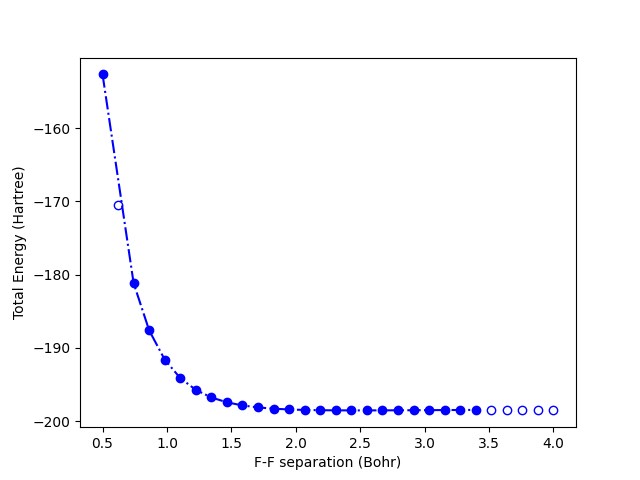

In [54]:
%matplotlib widget

plt.plot(R[is_converged], energy[is_converged], 'bo')
plt.plot(R[is_converged], energy[is_converged], 'b-.')
plt.plot(R[[not x for x in is_converged]], energy[[not x for x in is_converged]], 'bo', markerfacecolor='none')
plt.xlabel('F-F separation (Bohr)')
plt.ylabel('Total Energy (Hartree)')
# plt.ylim([-198.55, -198.3])
# plt.xlim([1.75, 3.5])